# Ex 1.2: A simple parallel MapReduce framework in Python
Now we use the [*multiprocessing*](https://docs.python.org/3/library/multiprocessing.html) lib to actually do things in parallel

In [84]:
import collections
import itertools
import multiprocessing


class SimpleMapReduce:

    def __init__(self, map_func, reduce_func, num_workers=None):
        """
        map_func

          Function to map inputs to intermediate data. Takes as
          argument one input value and returns a tuple with the
          key and a value to be reduced.

        reduce_func

          Function to reduce partitioned version of intermediate
          data to final output. Takes as argument a key as
          produced by map_func and a sequence of the values
          associated with that key.

        num_workers

          The number of workers to create in the pool. Defaults
          to the number of CPUs available on the current host.
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = multiprocessing.Pool(num_workers)

    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key
        and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()

    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions
        given.

        inputs
          An iterable containing the input data to be processed.

        chunksize=1
          The portion of the input data to hand to each worker.
          This can be used to tune performance during the mapping
          phase.
        """
        map_responses = self.pool.map(
            self.map_func,
            inputs,
            chunksize=chunksize,
        )
        partitioned_data = self.partition(
            itertools.chain(*map_responses)
        )
        reduced_values = self.pool.map(
            self.reduce_func,
            partitioned_data,
        )
        return reduced_values

### A Word Count example

In [34]:
import string

# map - read file and count words
def file_to_words(filename):
    """Read a file and return a sequence of
    (word, occurences) values.
    """
    STOP_WORDS = set([
        'a', 'an', 'and', 'are', 'as', 'be', 'by', 'for', 'if',
        'in', 'is', 'it', 'of', 'or', 'py', 'rst', 'that', 'the',
        'to', 'with',
    ])
    TR = str.maketrans({
        p: ' '
        for p in string.punctuation
    })

    print('{} reading {}'.format(
        multiprocessing.current_process().name, filename))
    output = []

    with open(filename, 'rt') as f:
        for line in f:
            # Skip comment lines.
            if line.lstrip().startswith('..'):
                continue
            line = line.translate(TR)  # Strip punctuation
            for word in line.split():
                word = word.lower()
                if word.isalpha() and word not in STOP_WORDS:
                    output.append((word, 1))
    return output

# reduce
def count_words(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurences.
    """
    word, occurences = item
    return (word, sum(occurences))

In [35]:
import operator
import glob #easy file access

input_files = glob.glob('*.rst')#get all text files names 

mapper = SimpleMapReduce(file_to_words, count_words)#get mapreduce instance with custom map and reduce functions
word_counts = mapper(input_files)#call parallel mapreduce on files

word_counts.sort(key=operator.itemgetter(1))#sort results
word_counts.reverse()

print('\nTOP 20 WORDS BY FREQUENCY\n')
top20 = word_counts[:20]
longest = max(len(word) for word, count in top20)
for word, count in top20:
    print('{word:<{len}}: {count:5}'.format(
            len=longest + 1,
            word=word,
            count=count)
    )

TypeError: __call__() missing 1 required positional argument: 'y_pred'

## K-Means implementation
Use the simple frame work to implement K-Means

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

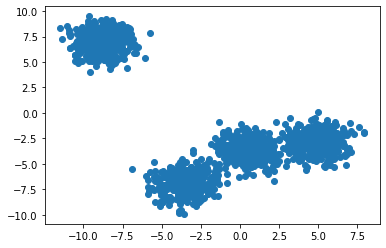

In [63]:
#generate data with K=4
X, y = make_blobs(n_samples=1500, centers=4)
plt.scatter(X[:, 0], X[:, 1])

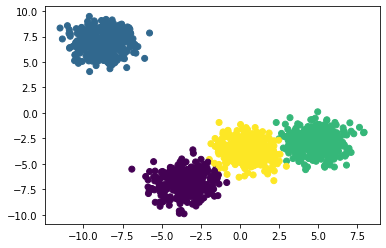

In [64]:
#K-Means ref implementation
k = KMeans(n_clusters=4, random_state=0)
y_pred = k.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [65]:
k.cluster_centers_

array([[-3.55469841, -6.85571077],
       [-8.79604434,  6.95855495],
       [ 4.81923421, -2.90609552],
       [ 0.44921992, -3.70978241]])

In [123]:
#implement map -> assign data to center 

def kMap(a):
    outputMeans = []
    ind = np.where(X==a)[0][0]
    outputMeans.append((y_pred[ind],a))
    return outputMeans


In [116]:
avs=kMap(X[1])

In [134]:
#implement reduce -> compute new centers
def kReduce(means):
    return (means[0], sum(means[1])/means[1].shape)


In [114]:
kReduce(avs)

TypeError: cannot unpack non-iterable NoneType object

In [121]:
#init centers
center = X[np.random.randint(X.shape[0], size=4), :]#get 4 random datapoints
print('init center', center)

init center [[-3.98404677 -7.55963344]
 [ 0.31384842 -5.47047947]
 [ 4.49726801 -3.9987451 ]
 [ 0.9551339  -2.73775568]]


In [135]:
#use framework
mapper = SimpleMapReduce(kMap, kReduce)#get mapreduce instance with custom map and reduce functions
center = mapper(X)#call parallel mapreduce oo data

AttributeError: 'list' object has no attribute 'shape'